In [10]:
#SL: Using Well Log data time series data,update every 10 points. Using KISSGP with SpectralMixtureKernel
#Load data

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel,SpectralMixtureKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from numpy import genfromtxt
import numpy as np
import math
from matplotlib.pyplot import cm 

%matplotlib inline


In [3]:
my_data_load = genfromtxt('data_final.csv', delimiter=',')

cut_off=976


train_Xs_np=my_data_load[:976,0]
train_Ys_np=my_data_load[:976,1]
train_Clusters=my_data_load[:976,2]

totalN=my_data_load.shape[0]
updateN=10
totalNUpdates=np.floor((totalN-cut_off)/updateN)


train_Xs=Variable(torch.from_numpy(train_Xs_np).type(torch.FloatTensor))
train_Ys=Variable(torch.from_numpy(train_Ys_np).type(torch.FloatTensor))

n_cluster=int(max(train_Clusters))

train_x=[]
train_y=[]
for i in range(n_cluster):
    train_x.append(Variable(torch.from_numpy(train_Xs_np[train_Clusters==i+1]).type(torch.FloatTensor)))
    train_y.append(Variable(torch.from_numpy(train_Ys_np[train_Clusters==i+1]).type(torch.FloatTensor)))
    
    
test_X_np=my_data_load[976:,0]
test_Y_np=my_data_load[976:,1]
test_Cluster=my_data_load[976:,2]

test_X=Variable(torch.from_numpy(test_X_np).type(torch.FloatTensor))
test_Y=Variable(torch.from_numpy(test_Y_np).type(torch.FloatTensor))


gridRangeMin=train_Xs_np[0]
gridRangeMax=test_X_np[-1]

ymin=min(train_Ys_np)+10
ymax=max(train_Ys_np)+10

currentCluster=int(train_Clusters[-1])


In [4]:
class LatentFunction(gpytorch.GridInducingPointModule):
    def __init__(self):
        super(LatentFunction, self).__init__(grid_size=50, grid_bounds=[(gridRangeMin, gridRangeMax)])
        self.mean_module = ConstantMean(constant_bounds=[ymin,ymax])
        self.covar_module = SpectralMixtureKernel(n_mixtures=10)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

class GPRegressionModel(gpytorch.GPModel):
    def __init__(self):
        super(GPRegressionModel,self).__init__(GaussianLikelihood())
        self.latent_function = LatentFunction()
        
    def forward(self, x):
        return self.latent_function(x)
    

    
    
models=[]
for i in range(n_cluster):
    models.append(GPRegressionModel())

In [5]:
def plot_model_and_predictions(models, test_x, closest_cluster,i, plot_train_data=True):
    plt.figure(i)
    f, observed_ax = plt.subplots(1, 1, figsize=(5, 5))
    observed_pred = models[closest_cluster-1](test_x)
    colors=iter(cm.rainbow(np.linspace(0,1,n_cluster)))
    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            for i in range(n_cluster):
                ax.plot(train_x[i].data.numpy(), train_y[i].data.numpy(),'*',color=next(colors),label='_nolegend_')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'r')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.legend(['Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

def EucDist(x1,x2):
    n, d = x1.size()
    m, _ = x2.size()

    dist = 2 * x1.matmul(x2.transpose(0, 1))

    x1_squared = torch.bmm(x1.view(n, 1, d), x1.view(n, d, 1))
    x1_squared = x1_squared.view(n, 1).expand(n, m)
    x2_squared = torch.bmm(x2.view(m, 1, d), x2.view(m, d, 1))
    x2_squared = x2_squared.view(1, m).expand(n, m)
    dist=x1_squared+x2_squared-dist
    dist=torch.norm(dist,2)
    return dist

def updateClusterParameters(bestCloster,model,train_x,train_y):
    #update the clustering parameters
    print('Training Cluster %d' % (bestCloster))
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    optimizer.n_iter = 0
    for i in range(50):
        optimizer.zero_grad()
        output = model(train_x[bestCloster-1])
        loss = -model.marginal_log_likelihood(output, train_y[bestCloster-1])
        loss.backward()
        optimizer.n_iter += 1
        #print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.data[0]))
        optimizer.step()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.data[0]))
    _ = model.eval()


In [6]:
#online setting update it for every n points
from scipy.stats import chi2

def findCluster(updateN,currentCluster):
    updated_X=Variable(torch.from_numpy(test_X_np[:updateN]).float())
    updated_Y=Variable(torch.from_numpy(test_Y_np[:updateN]).float())

#cluster those points

    updated_X=torch.unsqueeze(updated_X, 1)
    updated_X=updated_X.contiguous()

    updated_Y=torch.unsqueeze(updated_Y, 1)
    updated_Y=updated_Y.contiguous()

    likelihood=[]
    for i in range(n_cluster):
    
    #K_ss=SpectralMixtureKernel(n_mixtures=10)
    #p=K_ss.forward(updated_X, updated_X)
    #p_inv=torch.inverse(p)

        pred = models[i](updated_X)
        pred=torch.unsqueeze(pred.mean(), 1)
        dist=EucDist(pred,updated_Y)
    #M=updated_Y-pred.mean()
    #Mt=torch.unsqueeze(M, 0)
    #M=torch.unsqueeze(M, 1)
    #ts=Mt.mm(p_inv)
    #ts=ts.mm(M)
    #print(ts)
    #likelihood.append(chi2.cdf(ts.data[0].numpy()[0],10))
        likelihood.append(dist.data[0])
    

    clostest=min(likelihood)
    bestCloster=likelihood.index(min(likelihood))+1

    print('Old Closter is ', currentCluster)
    print('Best Closter is ', bestCloster)

    
    return bestCloster,updated_X,updated_Y

def updating(bestCloster,updateN):
    #update training and testing
    updated_X=torch.squeeze(updated_X,1)
    updated_Y=torch.squeeze(updated_Y,1)
    train_x[bestCloster-1]=torch.cat((train_x[bestCloster-1], updated_X), 0)
    train_y[bestCloster-1]=torch.cat((train_y[bestCloster-1], updated_Y), 0)

    test_X=Variable(torch.from_numpy(test_X_np[updateN:]).float())
    test_Y=Variable(torch.from_numpy(test_Y_np[updateN:]).float())

    test_X_np=test_X_np[updateN:]
    test_Y_np=test_Y_np[updateN:]

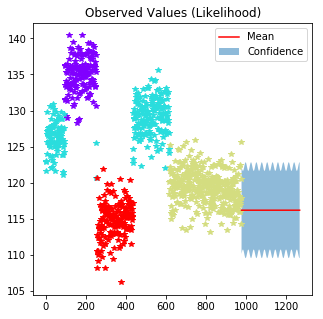

In [7]:
f = plot_model_and_predictions(models, test_X, currentCluster,0, plot_train_data=True)

Training Cluster 1
Iter 50/50 - Loss: 2.418
Training Cluster 2
Iter 50/50 - Loss: 2.425
Training Cluster 3
Iter 50/50 - Loss: 2.248
Training Cluster 4
Iter 50/50 - Loss: 2.360


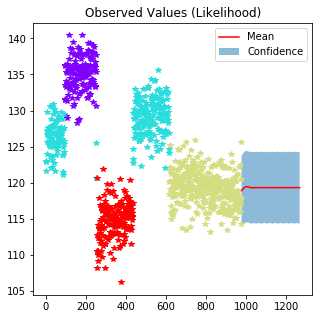

In [8]:
for i in range(n_cluster):
      updateClusterParameters(i+1,models[i],train_x,train_y)

models[currentCluster-1].condition(train_x[currentCluster-1],train_y[currentCluster-1])
f = plot_model_and_predictions(models, test_X, currentCluster,0, plot_train_data=True)

Old Closter is  3
Best Closter is  2
Training Cluster 2
Iter 50/50 - Loss: 2.391
Training Cluster 2
Iter 50/50 - Loss: 2.390
Old Closter is  2
Best Closter is  2
Training Cluster 2
Iter 50/50 - Loss: 2.385
Old Closter is  2
Best Closter is  2
Training Cluster 2
Iter 50/50 - Loss: 2.370
Old Closter is  2
Best Closter is  2
Training Cluster 2
Iter 50/50 - Loss: 2.362
Old Closter is  2
Best Closter is  2
Training Cluster 2
Iter 50/50 - Loss: 2.380
Old Closter is  2
Best Closter is  2
Training Cluster 2
Iter 50/50 - Loss: 2.350
Old Closter is  2
Best Closter is  3
Training Cluster 3
Iter 50/50 - Loss: 2.244
Training Cluster 3
Iter 50/50 - Loss: 2.260
Old Closter is  3
Best Closter is  3
Training Cluster 3
Iter 50/50 - Loss: 2.257
Old Closter is  3
Best Closter is  3
Training Cluster 3
Iter 50/50 - Loss: 2.252
Old Closter is  3
Best Closter is  3
Training Cluster 3
Iter 50/50 - Loss: 2.256
Old Closter is  3
Best Closter is  1
Training Cluster 1
Iter 50/50 - Loss: 2.399
Training Cluster 1
It

/home/Serena/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Old Closter is  4
Best Closter is  4
Training Cluster 4
Iter 50/50 - Loss: 2.328
Old Closter is  4
Best Closter is  4
Training Cluster 4
Iter 50/50 - Loss: 2.340
Old Closter is  4
Best Closter is  4
Training Cluster 4
Iter 50/50 - Loss: 2.327
Old Closter is  4
Best Closter is  4
Training Cluster 4
Iter 50/50 - Loss: 2.315
Old Closter is  4
Best Closter is  4
Training Cluster 4
Iter 50/50 - Loss: 2.312
Old Closter is  4
Best Closter is  4
Training Cluster 4
Iter 50/50 - Loss: 2.317
Old Closter is  4
Best Closter is  4
Training Cluster 4
Iter 50/50 - Loss: 2.307
Old Closter is  4
Best Closter is  4
Training Cluster 4
Iter 50/50 - Loss: 2.313
Old Closter is  4
Best Closter is  4
Training Cluster 4
Iter 50/50 - Loss: 2.300


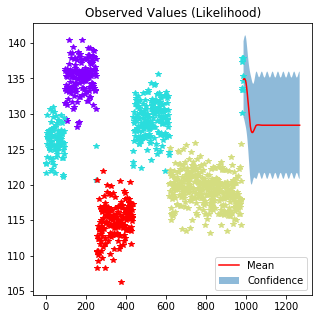

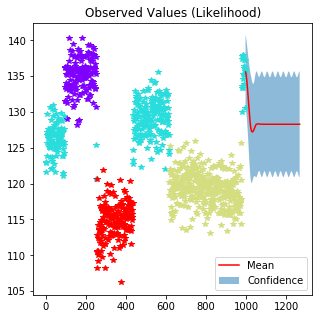

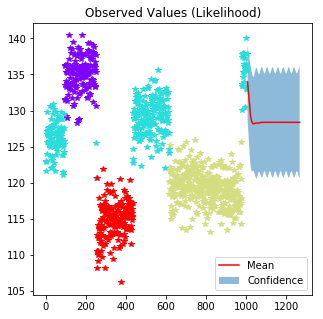

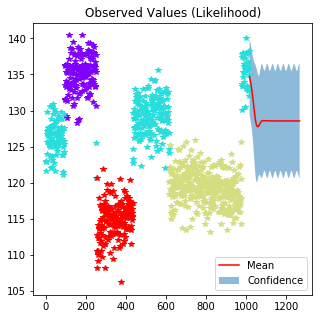

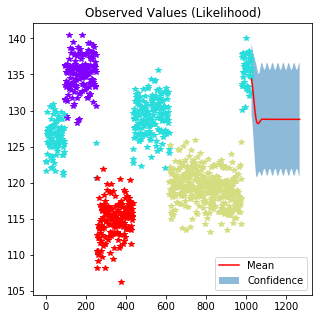

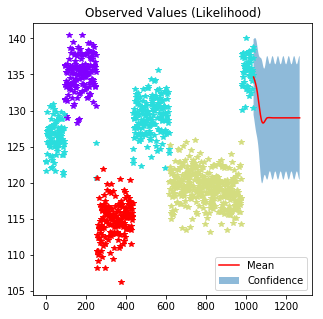

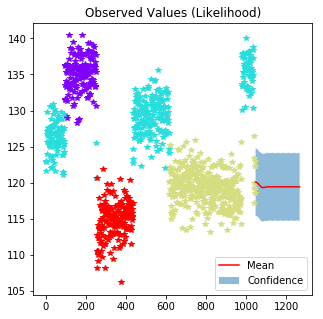

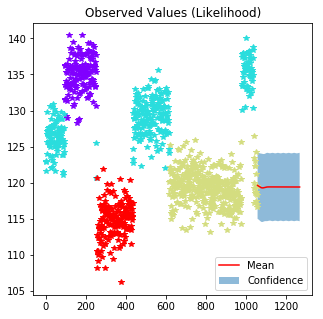

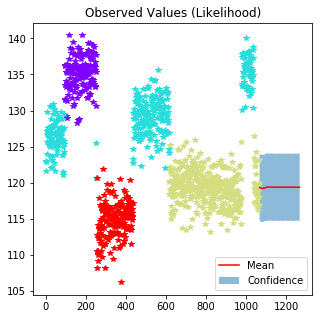

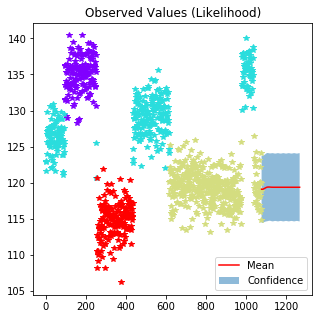

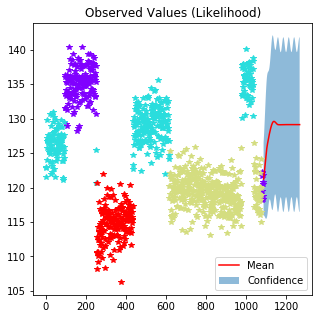

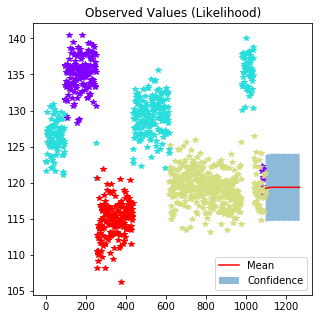

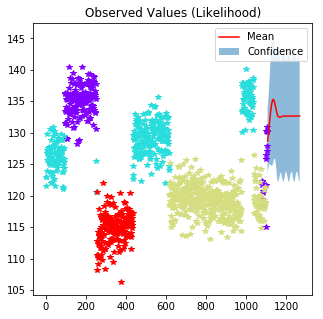

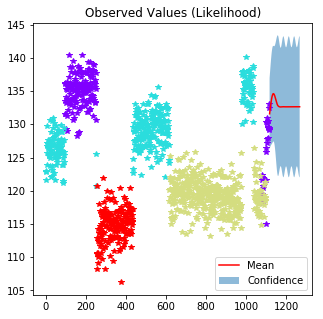

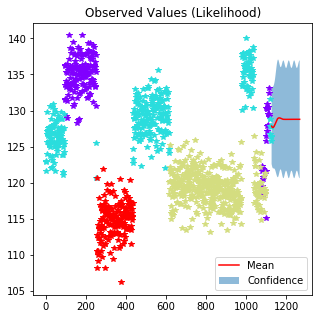

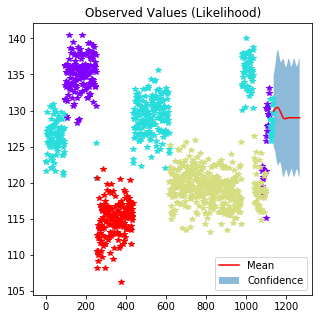

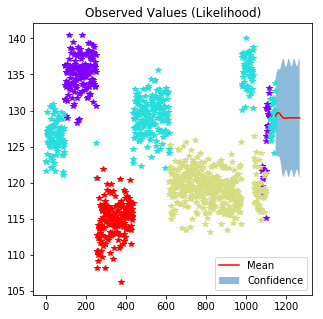

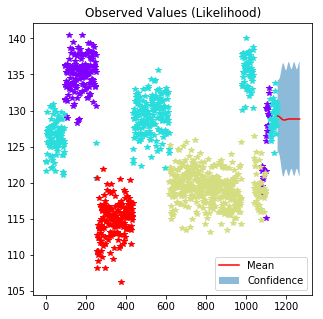

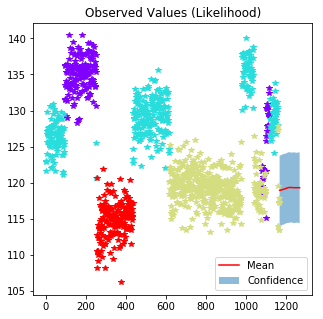

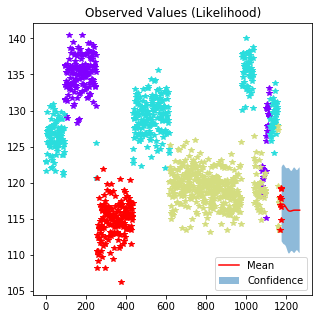

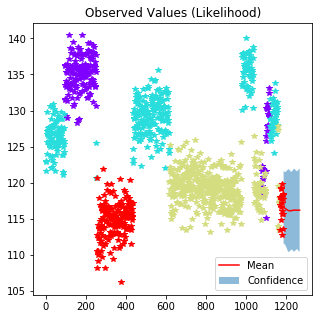

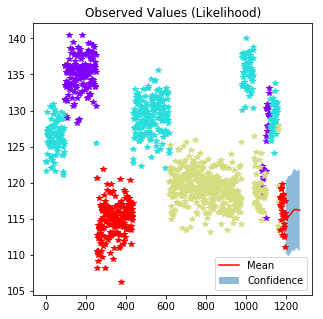

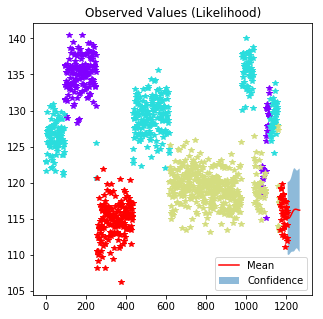

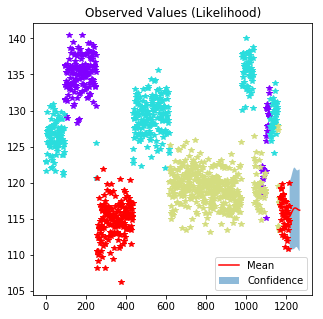

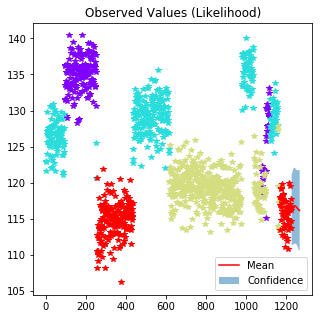

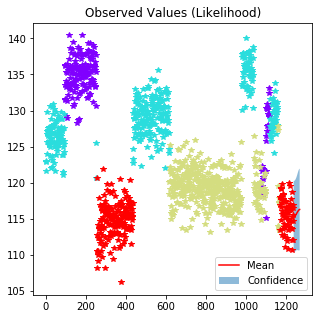

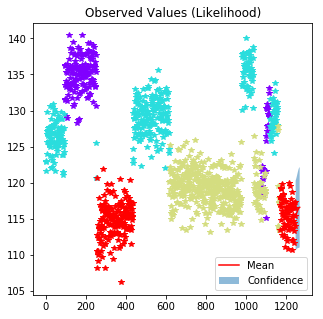

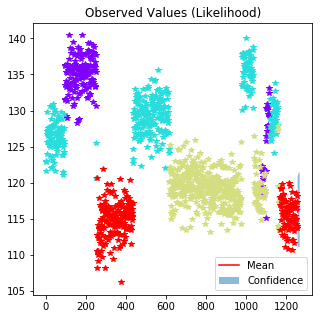

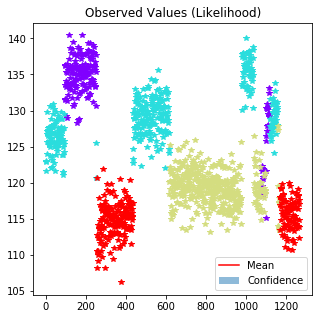

In [9]:
#for k in range(int(totalNUpdates)):
for k in range(int(totalNUpdates)):
    newCluster,updated_X,updated_Y=findCluster(updateN,currentCluster)
    if newCluster!=currentCluster:
        updateClusterParameters(newCluster,models[newCluster-1],train_x,train_y)
    currentCluster=newCluster
    updated_X=torch.squeeze(updated_X,1)
    updated_Y=torch.squeeze(updated_Y,1)
    train_x[currentCluster-1]=torch.cat((train_x[currentCluster-1], updated_X), 0)
    train_y[currentCluster-1]=torch.cat((train_y[currentCluster-1], updated_Y), 0)

    test_X=Variable(torch.from_numpy(test_X_np[updateN:]).float())
    test_Y=Variable(torch.from_numpy(test_Y_np[updateN:]).float())

    test_X_np=test_X_np[updateN:]
    test_Y_np=test_Y_np[updateN:]
    updateClusterParameters(currentCluster,models[currentCluster-1],train_x,train_y)
    models[currentCluster-1].condition(train_x[currentCluster-1],train_y[currentCluster-1])
    f = plot_model_and_predictions(models, test_X, currentCluster,i, plot_train_data=True)